# FenGen个性化联邦学习例子

In [1]:
%load_ext autoreload
%autoreload 2

## 在secretflow环境创造3个实体[Alice，Bob，Charlie]，其中 Alice, Bob和Charlie 是三个PYU，Alice和Bob角色是client，Charlie角色是server。

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

/home/yang/anaconda3/envs/mysf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-26 19:44:01,656	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


The version of SecretFlow: 1.9.0.dev20240726


/home/yang/anaconda3/envs/mysf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-26 19:44:04,207	INFO worker.py:1724 -- Started a local Ray instance.


In [3]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

In [4]:
## 导入相关依赖

In [5]:
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F
import torch

2024-08-26 19:44:07.645082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 数据划分，这里模拟数据不平衡2:8分

In [6]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.2, bob: 0.8},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

## 定义一个神经网络模型，输出是logit

In [7]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x, start_layer_idx=0):
        if start_layer_idx == -1:
            x = self.fc(x)
            return x
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return x

定义神经网络模型的损失函数和优化器

In [8]:
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)

## 准备FedGen相关工作，生成器模型等

生成器模型

In [9]:
class GeneratorModel(BaseModule):
    def __init__(
        self, hidden_dimension, latent_dimension, n_class, noise_dim, embedding=False
    ):
        super(GeneratorModel, self).__init__()
        self.hidden_dim = hidden_dimension
        self.latent_dim = latent_dimension
        self.n_class = n_class
        self.noise_dim = noise_dim
        self.embedding = embedding
        input_dim = (
            self.noise_dim * 2 if self.embedding else self.noise_dim + self.n_class
        )
        self.build_network(input_dim)

    def build_network(self, input_dim):
        if self.embedding:
            self.embedding_layer = nn.Embedding(self.n_class, self.noise_dim)
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
        )
        # Representation layer
        self.representation_layer = nn.Linear(self.hidden_dim, self.latent_dim)
        # print(f"Build last layer {self.hidden_dim} X {self.latent_dim}")

    def forward(self, labels, latent_layer_idx=-1, verbose=True):
        """
        G(Z|y) or G(X|y):
        Generate either latent representation( latent_layer_idx < 0) or raw image (latent_layer_idx=0) conditional on labels.
        :param labels:
        :param latent_layer_idx:
            if -1, generate latent representation of the last layer,
            -2 for the 2nd to last layer, 0 for raw images.
        :param verbose: also return the sampled Gaussian noise if verbose = True
        :return: a dictionary of output information.
        """
        result = {}
        batch_size = labels.shape[0]
        eps = torch.rand((batch_size, self.noise_dim))  # sampling from Gaussian
        if verbose:
            result['eps'] = eps
        if self.embedding:  # embedded dense vector
            y_input = self.embedding_layer(labels)
        else:  # one-hot (sparse) vector
            y_input = torch.FloatTensor(batch_size, self.n_class)
            y_input.zero_()
            # labels = labels.view
            y_input.scatter_(1, labels.view(-1, 1), 1)
        z = torch.cat((eps, y_input), dim=1)
        ### FC layers
        for layer in self.fc_layers:
            z = layer(z)
        z = self.representation_layer(z)
        result['output'] = z
        return result


generator = GeneratorModel(
    hidden_dimension=256,
    latent_dimension=192,
    n_class=10,
    noise_dim=64,
    embedding=False,
)
print(generator)

GeneratorModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=74, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (representation_layer): Linear(in_features=256, out_features=192, bias=True)
)


DiversityLoss是一个自定义的损失函数类

In [10]:
class DiversityLoss(nn.Module):
    """
    Diversity loss for improving the performance.
    """

    def __init__(self, metric):
        """
        Class initializer.
        """
        super().__init__()
        self.metric = metric
        self.cosine = nn.CosineSimilarity(dim=2)

    def compute_distance(self, tensor1, tensor2, metric):
        """
        Compute the distance between two tensors.
        """
        if metric == 'l1':
            return torch.abs(tensor1 - tensor2).mean(dim=(2,))
        elif metric == 'l2':
            return torch.pow(tensor1 - tensor2, 2).mean(dim=(2,))
        elif metric == 'cosine':
            return 1 - self.cosine(tensor1, tensor2)
        else:
            raise ValueError(metric)

    def pairwise_distance(self, tensor, how):
        """
        Compute the pairwise distances between a Tensor's rows.
        """
        n_data = tensor.size(0)
        tensor1 = tensor.expand((n_data, n_data, tensor.size(1)))
        tensor2 = tensor.unsqueeze(dim=1)
        return self.compute_distance(tensor1, tensor2, how)

    def forward(self, noises, layer):
        """
        Forward propagation.
        """
        if len(layer.shape) > 2:
            layer = layer.view((layer.size(0), -1))
        layer_dist = self.pairwise_distance(layer, how=self.metric)
        noise_dist = self.pairwise_distance(noises, how='l2')
        return torch.exp(torch.mean(-noise_dist * layer_dist))

FedGen需要有generator_config配置，关于生成器模型需要的损失函数，优化器等

In [11]:
kl_div_loss = nn.KLDivLoss(reduction="batchmean")
diversity_loss = DiversityLoss(metric='l1')
generative_optimizer = torch.optim.Adam(
    params=generator.parameters(),
    lr=0.0003,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,
    amsgrad=False,
)
generative_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer=generative_optimizer, gamma=0.98
)
cross_entropy_loss = nn.CrossEntropyLoss()
generator_config = {
    'generator_model': generator,
    'optimizer': generative_optimizer,
    'scheduler': generative_lr_scheduler,
    'loss_fn': cross_entropy_loss,
    'kl_div_loss': kl_div_loss,
    'diversity_loss': diversity_loss,
    'num_classes': 10,
    'epochs': 20,
    'batch_size': 32,
}

## 进行联邦学习

In [12]:
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

device_list = [alice, bob]
server = charlie
aggregator = SecureAggregator(server, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server,
    device_list=device_list,
    model=model_def,
    strategy='fed_gen',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
    aggregator=aggregator,
    generator_config=generator_config,
)
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party bob.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedGen'> with party alice.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedGen'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fdfb655c550>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fdfb655c250>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fdfb655c4f0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7fdfb655c370>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_sampling_rate': None, 'epochs': 20, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(p

Epoch 1/20


Train Processing: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 374/375 [03:07<00:00,  2.03it/s]/home/yang/PycharmProjects/secretflow/secretflow/ml/nn/metrics.py:62: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
2024-08-26 19:47:26.145363: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Train Processing: : 100%|▉| 374/375 [03:07<00:00,  1.99it/s, {'multiclassaccuracy': 0.88055205, 'multiclassprecision': 0.88055205, 'val_multiclassaccuracy': 0.8960625, 'val_multicl
Train Processing: :   0%|                                               

Epoch 2/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.32098978757858276, 'train_multiclassaccuracy': tensor(0.8837), 'train_multiclassprecision': tensor(0.8837), 'val_eval_multiclassaccuracy': tensor(0.8785), 'val_eval_multiclassprecision': tensor(0.8785)}


Train Processing: : 100%|▉| 374/375 [03:10<00:00,  1.96it/s, {'multiclassaccuracy': 0.94209373, 'multiclassprecision': 0.94209373, 'val_multiclassaccuracy': 0.93018746, 'val_multic
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 3/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.15948446094989777, 'train_multiclassaccuracy': tensor(0.9448), 'train_multiclassprecision': tensor(0.9448), 'val_eval_multiclassaccuracy': tensor(0.9160), 'val_eval_multiclassprecision': tensor(0.9160)} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Train Processing: : 100%|▉| 374/375 [03:12<00:00,  1.95it/s, {'multiclassaccuracy': 0.9514792, 'multiclassprecision': 0.9514792, 'val_multiclassaccuracy': 0.9436875, 'val_multiclas
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 4/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.09892704337835312, 'train_multiclassaccuracy': tensor(0.9525), 'train_multiclassprecision': tensor(0.9525), 'val_eval_multiclassaccuracy': tensor(0.9315), 'val_eval_multiclassprecision': tensor(0.9315)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:13<00:00,  1.93it/s, {'multiclassaccuracy': 0.9555625, 'multiclassprecision': 0.9555625, 'val_multiclassaccuracy': 0.94893754, 'val_multicla
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 5/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.07739856094121933, 'train_multiclassaccuracy': tensor(0.9563), 'train_multiclassprecision': tensor(0.9563), 'val_eval_multiclassaccuracy': tensor(0.9375), 'val_eval_multiclassprecision': tensor(0.9375)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:14<00:00,  1.92it/s, {'multiclassaccuracy': 0.95801044, 'multiclassprecision': 0.95801044, 'val_multiclassaccuracy': 0.951875, 'val_multicla
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 6/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.06668166071176529, 'train_multiclassaccuracy': tensor(0.9591), 'train_multiclassprecision': tensor(0.9591), 'val_eval_multiclassaccuracy': tensor(0.9400), 'val_eval_multiclassprecision': tensor(0.9400)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:14<00:00,  1.92it/s, {'multiclassaccuracy': 0.9595833, 'multiclassprecision': 0.9595833, 'val_multiclassaccuracy': 0.9544375, 'val_multiclas
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 7/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.05800740793347359, 'train_multiclassaccuracy': tensor(0.9601), 'train_multiclassprecision': tensor(0.9601), 'val_eval_multiclassaccuracy': tensor(0.9430), 'val_eval_multiclassprecision': tensor(0.9430)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:15<00:00,  1.91it/s, {'multiclassaccuracy': 0.9607396, 'multiclassprecision': 0.9607396, 'val_multiclassaccuracy': 0.95625, 'val_multiclassp
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 8/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.055014461278915405, 'train_multiclassaccuracy': tensor(0.9605), 'train_multiclassprecision': tensor(0.9605), 'val_eval_multiclassaccuracy': tensor(0.9455), 'val_eval_multiclassprecision': tensor(0.9455)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:16<00:00,  1.90it/s, {'multiclassaccuracy': 0.96203125, 'multiclassprecision': 0.96203125, 'val_multiclassaccuracy': 0.959875, 'val_multicla
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 9/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.05439997464418411, 'train_multiclassaccuracy': tensor(0.9613), 'train_multiclassprecision': tensor(0.9613), 'val_eval_multiclassaccuracy': tensor(0.9520), 'val_eval_multiclassprecision': tensor(0.9520)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:20<00:00,  1.87it/s, {'multiclassaccuracy': 0.9632813, 'multiclassprecision': 0.9632813, 'val_multiclassaccuracy': 0.96, 'val_multiclassprec
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 10/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.054123666137456894, 'train_multiclassaccuracy': tensor(0.9627), 'train_multiclassprecision': tensor(0.9627), 'val_eval_multiclassaccuracy': tensor(0.9510), 'val_eval_multiclassprecision': tensor(0.9510)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:27<00:00,  1.80it/s, {'multiclassaccuracy': 0.9642917, 'multiclassprecision': 0.9642917, 'val_multiclassaccuracy': 0.961625, 'val_multiclass
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 11/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.05435159057378769, 'train_multiclassaccuracy': tensor(0.9632), 'train_multiclassprecision': tensor(0.9632), 'val_eval_multiclassaccuracy': tensor(0.9535), 'val_eval_multiclassprecision': tensor(0.9535)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:28<00:00,  1.79it/s, {'multiclassaccuracy': 0.96540624, 'multiclassprecision': 0.96540624, 'val_multiclassaccuracy': 0.9615625, 'val_multicl
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 12/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.05210527032613754, 'train_multiclassaccuracy': tensor(0.9641), 'train_multiclassprecision': tensor(0.9641), 'val_eval_multiclassaccuracy': tensor(0.9540), 'val_eval_multiclassprecision': tensor(0.9540)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:25<00:00,  1.82it/s, {'multiclassaccuracy': 0.9661667, 'multiclassprecision': 0.9661667, 'val_multiclassaccuracy': 0.9625, 'val_multiclasspr
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 13/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.04824415221810341, 'train_multiclassaccuracy': tensor(0.9644), 'train_multiclassprecision': tensor(0.9644), 'val_eval_multiclassaccuracy': tensor(0.9555), 'val_eval_multiclassprecision': tensor(0.9555)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:24<00:00,  1.83it/s, {'multiclassaccuracy': 0.9668958, 'multiclassprecision': 0.9668958, 'val_multiclassaccuracy': 0.9633125, 'val_multiclas
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 14/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.04378644749522209, 'train_multiclassaccuracy': tensor(0.9653), 'train_multiclassprecision': tensor(0.9653), 'val_eval_multiclassaccuracy': tensor(0.9560), 'val_eval_multiclassprecision': tensor(0.9560)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:17<00:00,  1.90it/s, {'multiclassaccuracy': 0.9681667, 'multiclassprecision': 0.9681667, 'val_multiclassaccuracy': 0.96449995, 'val_multicla
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 15/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.040395185351371765, 'train_multiclassaccuracy': tensor(0.9669), 'train_multiclassprecision': tensor(0.9669), 'val_eval_multiclassaccuracy': tensor(0.9575), 'val_eval_multiclassprecision': tensor(0.9575)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:17<00:00,  1.89it/s, {'multiclassaccuracy': 0.96953124, 'multiclassprecision': 0.96953124, 'val_multiclassaccuracy': 0.96500003, 'val_multic
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 16/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.038736842572689056, 'train_multiclassaccuracy': tensor(0.9688), 'train_multiclassprecision': tensor(0.9688), 'val_eval_multiclassaccuracy': tensor(0.9580), 'val_eval_multiclassprecision': tensor(0.9580)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:17<00:00,  1.90it/s, {'multiclassaccuracy': 0.9702604, 'multiclassprecision': 0.9702604, 'val_multiclassaccuracy': 0.9661875, 'val_multiclas
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 17/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.03759680688381195, 'train_multiclassaccuracy': tensor(0.9695), 'train_multiclassprecision': tensor(0.9695), 'val_eval_multiclassaccuracy': tensor(0.9595), 'val_eval_multiclassprecision': tensor(0.9595)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:17<00:00,  1.89it/s, {'multiclassaccuracy': 0.97038543, 'multiclassprecision': 0.97038543, 'val_multiclassaccuracy': 0.9661875, 'val_multicl
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 18/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.03463209420442581, 'train_multiclassaccuracy': tensor(0.9695), 'train_multiclassprecision': tensor(0.9695), 'val_eval_multiclassaccuracy': tensor(0.9595), 'val_eval_multiclassprecision': tensor(0.9595)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:17<00:00,  1.89it/s, {'multiclassaccuracy': 0.9713646, 'multiclassprecision': 0.9713646, 'val_multiclassaccuracy': 0.96625, 'val_multiclassp
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 19/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.03343019261956215, 'train_multiclassaccuracy': tensor(0.9706), 'train_multiclassprecision': tensor(0.9706), 'val_eval_multiclassaccuracy': tensor(0.9595), 'val_eval_multiclassprecision': tensor(0.9595)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:18<00:00,  1.88it/s, {'multiclassaccuracy': 0.9715313, 'multiclassprecision': 0.9715313, 'val_multiclassaccuracy': 0.9666875, 'val_multiclas
Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 20/20
(ActorPYUFedGen pid=28273) {'train-loss': 0.033099215477705, 'train_multiclassaccuracy': tensor(0.9702), 'train_multiclassprecision': tensor(0.9702), 'val_eval_multiclassaccuracy': tensor(0.9600), 'val_eval_multiclassprecision': tensor(0.9600)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [03:18<00:00,  1.88it/s, {'multiclassaccuracy': 0.97160417, 'multiclassprecision': 0.97160417, 'val_multiclassaccuracy': 0.96625, 'val_multiclas


## 绘制结果

(ActorPYUFedGen pid=28273) {'train-loss': 0.0328717939555645, 'train_multiclassaccuracy': tensor(0.9704), 'train_multiclassprecision': tensor(0.9704), 'val_eval_multiclassaccuracy': tensor(0.9600), 'val_eval_multiclassprecision': tensor(0.9600)}


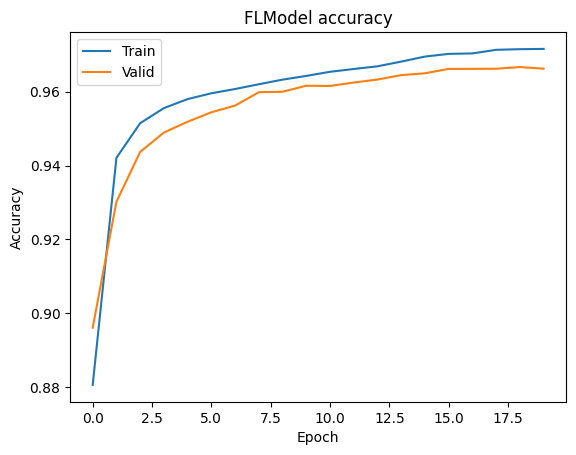

In [13]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()